# Prediction of Bike Sharing Demand 
## (Tigi, Daniel, Konniam)
## Description of Problem
## Tigi

## Baseline Analysis

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import make_scorer

# Set randomizer seed
np.random.seed(0)

We start by simply loading the data and extracting the most primitive features. We'll establish a baseline before continuing to more advanced algorithms and feature engineering.

In [18]:
# Prepare data for model fitting ()
# Train and test sets on local machines
file_paths = ['~/datasets/bike/train.csv', '~/datasets/bike/test.csv']

# Define function to clean train and test data
def clean_data(path):
    """
    Input: path of csv files (train or test)
    Output: dataframe with features deleted and added
    """
    df = pd.read_csv(path, parse_dates=[0], index_col=0)
    return df

# Clean train and test csv files
df_train = clean_data(file_paths[0])
df_test = clean_data(file_paths[1])

In [19]:
## Prepare data for sklearn
# Get feature names (excluding outcomes variables: casual, registered, count)
print ("Feature names: ")
print (df_train.columns.values[:-3])
# Print out first 10 training examples with outcome variables
print ("\nFirst 10 examples: ")
print (df_train.head(10))

# Extract numerical features 
train_data, train_labels = df_train.iloc[:, :-3].values, df_train.iloc[:, -3:].values
test_data = df_test.values

# Array sizes
print ("\nTrain data: {}".format(train_data.shape))
print ("Train labels: {}".format(train_labels.shape))
print ("Test data: {}".format(test_data.shape))

Feature names: 
['season' 'holiday' 'workingday' 'weather' 'temp' 'atemp' 'humidity'
 'windspeed']

First 10 examples: 
                     season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
2011-01-01 05:00:00       1        0           0        2   9.84  12.880   
2011-01-01 06:00:00       1        0           0        1   9.02  13.635   
2011-01-01 07:00:00       1        0           0        1   8.20  12.880   
2011-01-01 08:00:00       1        0           0        1   9.84  14.395   
2011-01-01 09:00:00       1        0        

### Baseline
The preferred evaluation criteria of this Kaggle competition is the RMSLE metric. First we start by prediction the outcome variable with its mean to set the baseline. We evaluate our results with a 5-fold validation, to balance between training a good model with low bias and having sufficient test examples to check accuracy.

In [8]:
## Evaluation criteria: Root Mean Squared Logarithmic Error (RMSLE)
def RMSLE(actual, predicted):
    """
    Inputs: actual counts, predicted counts
    Outputs: Root Mean Squared Logarithmic Error
    """
    return np.sqrt(np.mean(np.square(np.log(predicted+1) - np.log(actual+1))))

# Make a scoring object for GridSearch to use
RMSLE_scorer = make_scorer(RMSLE, greater_is_better=False)

In [71]:
## Baseline prediction (using the mean as a model)
# Evaluate with 10-fold cross-validation
base_preds = cross_val_predict(DummyRegressor(strategy="mean"), train_data, train_labels[:,2], cv=5)
print ("Baseline RMSLE: {:.3f}".format(RMSLE(train_labels[:,2], base_preds)))
print ("Baseline R2: {:.3f}".format(metrics.r2_score(train_labels[:, 2], base_preds)))

Baseline RMSLE: 1.591
Baseline R2: -0.072


### Linear Regression
Next up we'll try a linear regression model to see how much this improves upon the baseline.

In [72]:
## Ridge with default parameters
lr_preds = cross_val_predict(Ridge(), train_data, train_labels[:,2], cv=5)
# Prevent predictions from going below zero
lr_preds[lr_preds<0] = 0
print ("LR RMSLE: {:.3f}".format(RMSLE(train_labels[:,2], lr_preds)))
print ("LR R2: {:.3f}".format(metrics.r2_score(train_labels[:, 2], lr_preds)))

LR RMSLE: 1.479
LR R2: 0.141


Linear regression is able to bring down the RMSLE slightly and improve R2 to 14%.

## Data Exploration and Feature Engineering

How do users use the bike sharing system? This could give us insight into which features we need to include in our model.

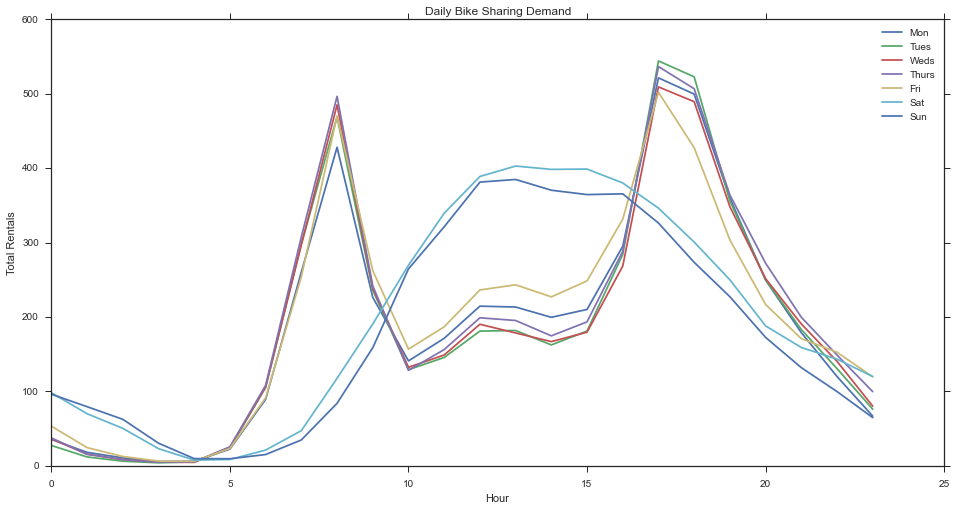

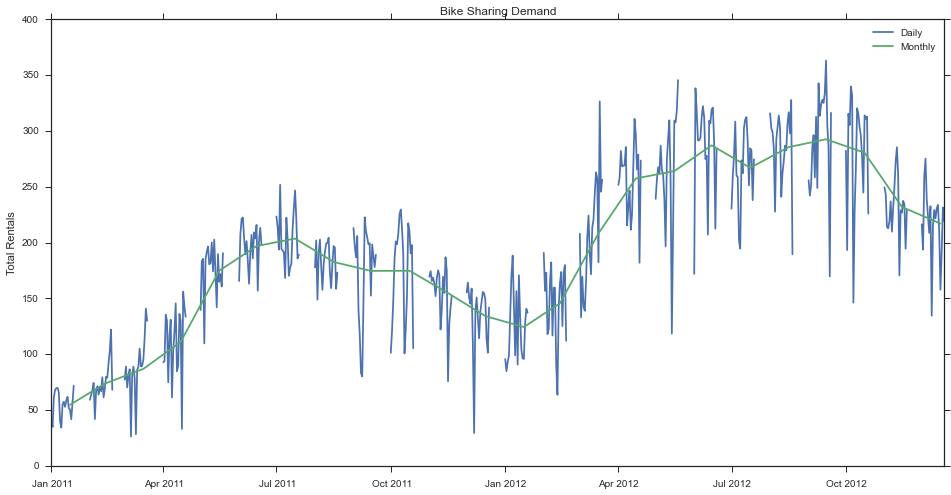

In [20]:
## How do users use the bike sharing system?
# Set plot styles
sns.set_style("ticks")

# Add dayofweek and hour feature
df_train.insert(0, "dayofweek", df_train.index.dayofweek)
df_train.insert(1, "hour", df_train.index.hour)

# Trends for demand daily for working day and non working day
df_hourly_dayofweek = df_train.groupby(["dayofweek", "hour"]).mean()
day_labels = ["Mon", "Tues", "Weds", "Thurs", "Fri", "Sat", "Sun"]
plt.figure(figsize = (16,8))
for d in range(7):
    plt.plot(df_hourly_dayofweek.ix[d].index, df_hourly_dayofweek.ix[d]['count'], label=day_labels[d])
title = plt.title('Daily Bike Sharing Demand')
xlabel = plt.xlabel('Hour')
ylabel = plt.ylabel('Total Rentals')
legend = plt.legend(frameon=False)

# Trends for demand over time
# Aggregate by day and by month
df_dailymean = df_train.resample('D', how='mean')
df_monthlymean = df_train.resample('M', how='mean')
# Plot time series
plt.figure(figsize = (16,8))
dailyplot = plt.plot(df_dailymean.index, df_dailymean['count'], label="Daily")
monthlyplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_monthlymean['count'], label="Monthly")
title = plt.title('Bike Sharing Demand')
ylabel = plt.ylabel('Total Rentals')
legend = plt.legend(frameon=False)

The first figure examines usage pattern on each day of the week. We clearly see that on weekdays, usage spikes in the morning around 8am and 5pm. This likely corresponds to people using the bike-sharing service as commute transportation. On weekends, the usage has a broad peak from 12pm to 4pm. People are likely using these bikes for leisure.  
The second figure shows the very high variance nature of bike sharing. The daily means fluctuate wildly. However, there seems to be a seasonal component to it. There is a local maximum around July, and a local minimum around January. The overall trend seems to be going up also (i.e. people use more bikes in 2012 compared to 2011).  
We used the above observations to engineer a few features:  
####Feature additions
- **year**: accounts for the overall growth of the system)
- **month**: accounts for seasonality
- **dayofyear**: a finer version of seasonality
- **hour**: captures daily fluctuation
- **dayofweek**: captures the behavior resulting from our 7-day based schedule
- **day**: captures behavior around the month, i.e people set goals to bike more in the beginning of the month
- **commute**: captures the peaks of commute transportation
- **monthly_count**: acts to smooth out our predictions

####Feature subtractions
- **season**: not necessary since we have "month" and "dayofyear", which are more granular
- **temp**: not necessary since we have "atemp" (what the temperature feels like), that is more accurate
- **windspeed**: not very prognostic from our testing

In [21]:
## Prepare data for model fitting, with feature engineering
# Train and test sets on local machines
file_paths = ['~/datasets/bike/train.csv', '~/datasets/bike/test.csv']

# Define function to clean train and test data
def clean_data(path):
    """
    Input: path of csv files (train or test)
    Output: dataframe with features deleted and added
    """
    df = pd.read_csv(path, parse_dates=[0], index_col=0)
    # Split datetime up into 6 components
    df.insert(0, "year", df.index.year)
    df.insert(1, "month", df.index.month)
    df.insert(2, "dayofyear", df.index.dayofyear)
    df.insert(3, "hour", df.index.hour)    
    df.insert(4, "dayofweek", df.index.dayofweek)
    df.insert(5, "day", df.index.day)    
    # Fill in missing values in humidity and windspeed
    df.loc[df["humidity"]==0, "humidity"] = np.nan
    df.loc[df["windspeed"]==0, "windspeed"] = np.nan    
    # Fill forward first, then, backwards (for first few missing values)
    df = df.fillna(method="ffill").fillna(method="bfill")
    # Features addition
    # Commute: account for spike in demand around commute hours
    commute_hours = [7,8,9,16,17,18,19]
    df.insert(7, "commute", ((df["workingday"]==1) & (df["hour"].isin(commute_hours))).astype(int))
    # Features removal (season and temp)
    df = df.drop(['season', 'temp', 'windspeed'], axis=1)    
    return df

# Clean train and test csv files
df_train = clean_data(file_paths[0])
df_test = clean_data(file_paths[1])

In [22]:
## Add monthly_count feature
# Join train and test data and column orders
df_all = pd.concat([df_train, df_test])
# Store original columns
old_cols = df_train.columns.tolist()
# Sort on index
df_all = df_all.sort()

# Introduce monthly demand variable from train data, and merge back into df_all dataframe
index = df_all.index
df_monthly_count = df_train.resample('M', how='mean')[["year", "month", "count"]]
df_monthly_count.columns.values[2] = "monthly_count"
df_all = pd.merge(df_all, df_monthly_count)
df_all.index = index

# Rearrange columns
new_cols = old_cols[:-3] + ["monthly_count"] + old_cols[-3:]
df_all = df_all[new_cols]
# Split into train and test again
df_train = df_all.loc[df_train.index]
df_test = df_all.ix[df_test.index, :-3]

With features added and subtracted from the dataframes, we can now prepare the data to sklearn.

In [23]:
## Prepare data for sklearn
# Get train feature names (excluding outcomes variables: casual, registered, count)
print ("Feature names: ")
print (df_train.columns.values[:-3])
# Print out first 5 training examples with outcome variables
print ("\nFirst 10 examples: ")
print (df_train.head(10))

# Extract numerical features 
train_data, train_labels = df_train.iloc[:, :-3].values, df_train.iloc[:, -3:].values
test_data = df_test.values

# Array sizes
print ("\nTrain data: {}".format(train_data.shape))
print ("Test data: {}".format(test_data.shape))
print ("Train labels: {}".format(train_labels.shape))

Feature names: 
['year' 'month' 'dayofyear' 'hour' 'dayofweek' 'day' 'commute' 'holiday'
 'workingday' 'weather' 'atemp' 'humidity' 'monthly_count']

First 10 examples: 
                     year  month  dayofyear  hour  dayofweek  day  commute  \
datetime                                                                     
2011-01-01 00:00:00  2011      1          1     0          5    1        0   
2011-01-01 01:00:00  2011      1          1     1          5    1        0   
2011-01-01 02:00:00  2011      1          1     2          5    1        0   
2011-01-01 03:00:00  2011      1          1     3          5    1        0   
2011-01-01 04:00:00  2011      1          1     4          5    1        0   
2011-01-01 05:00:00  2011      1          1     5          5    1        0   
2011-01-01 06:00:00  2011      1          1     6          5    1        0   
2011-01-01 07:00:00  2011      1          1     7          5    1        0   
2011-01-01 08:00:00  2011      1          1     8 

### Linear Regression
With feature engineering in place, let's first try our old friend linear regression.

In [77]:
## Ridge with default parameters
lr_preds = cross_val_predict(Ridge(), train_data, train_labels[:,2], cv=5)
# Prevent predictions from going below zero
lr_preds[lr_preds<0] = 0
# RMSLE and R2
print ("LR RMSLE: {:.3f}".format(RMSLE(train_labels[:,2], lr_preds)))
print ("LR R2: {:.3f}".format(metrics.r2_score(train_labels[:, 2], lr_preds)))

LR RMSLE: 1.327
LR R2: 0.617


Without feature engineering. Our error was 1.48, with a R2 of 14%. The new set of features really help explain more of the variance, bringing R2 to 62%.  

### k-Nearest Neighbors
Because our features are mostly numeric and continuous, and we have many examples relative to features, a k nearest neighbors model might work well here.

In [56]:
## kNN Regression
# Scale features first, then use 10-fold cross validation to check accuracy
k = 4
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors = k, weights = "distance"))
knn_preds = cross_val_predict(knn_pipe, train_data, train_labels[:,2], cv=5)

# RMSLE and R2
print ("kNN RMSLE: {:.3f}".format(RMSLE(train_labels[:,2], knn_preds)))
print ("kNN R2: {:.3f}".format(metrics.r2_score(train_labels[:, 2], knn_preds)))

kNN RMSLE: 0.841
kNN R2: 0.680


After some fine tuning, we improved the error to 0.841 and now explained 68% of the variance. The next thing we can try is a decision trees regressor.  

### Decision Trees
Because of its ability to model highly complicated boundaries, we expect decision tree to perform better than a kNN regression.

In [66]:
## Decision Tree Regression
# Ensure consistency of results
np.random.seed(0)
# Fit decision tree regressor
dt_preds = cross_val_predict(DecisionTreeRegressor(max_depth=10), train_data, train_labels[:,2], cv=5)

# RMSLE and R2
print ("DT RMSLE: {:.3f}".format(RMSLE(train_labels[:, 2], dt_preds)))
print ("DT R2: {:.3f}".format(metrics.r2_score(train_labels[:, 2], dt_preds)))

DT RMSLE: 0.539
DT R2: 0.773


### Random Forest
Random forest combines the results of many decision trees to reduce variance. We'll train a random forest model to see if it fits the data better than a decision tree.

In [65]:
## Random Forest Regressor
# Ensure consistency of results
np.random.seed(0)
# Fit random forest regressor
rf_preds = cross_val_predict(RandomForestRegressor(n_estimators = 50, max_features = 'auto'), 
                             train_data, train_labels[:, 2], cv=5, n_jobs=-1)

# RMSLE and R2
print ("RF RMSLE: {:.3f}".format(RMSLE(train_labels[:, 2], rf_preds)))
print ("RF R2: {:.3f}".format(metrics.r2_score(train_labels[:, 2], rf_preds)))

RF RMSLE: 0.473
RF R2: 0.844


Indeed, random forest performed quite well. We can try tuning the hyperparameters to see if we can improve upon the above results.

In [64]:
# Random Forest Grid Search (Parameters Tuning)
# Ensure consistency of results
np.random.seed(0)
# Set up GridSearchCV
rf_params = {'n_estimators': np.arange(1,30), 
             'max_features': ['auto', 'sqrt'],
             'max_depth': [None, 10]}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, scoring=RMSLE_scorer, cv=5)
rf_grid.fit(train_data, train_labels)

print (rf_grid.best_score_)
print (rf_grid.best_params_)

-0.544895257906
{'max_features': 'auto', 'n_estimators': 23, 'max_depth': None}


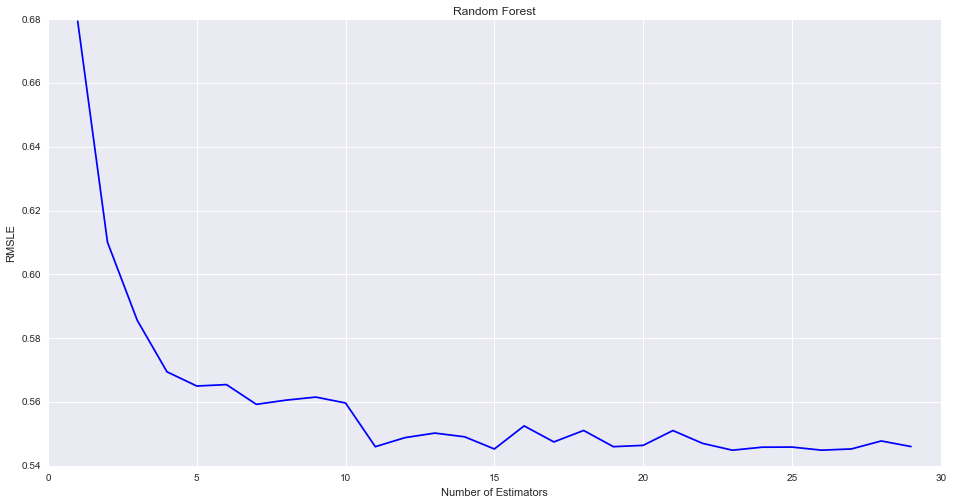

In [87]:
# Set plot styles
sns.set_style("darkgrid")
# Random forest plot
accuracies = [-rf_grid.grid_scores_[i][1] for i in range(29)]
plt.figure(figsize=(16,8))
scatter = plt.plot(rf_params["n_estimators"], accuracies, 'b')
title = plt.title ("Random Forest")
xlabel = plt.xlabel ("Number of Estimators")
ylabel = plt.ylabel ("RMSLE")

Note: This error (computed by GridSearchCV is computed differently from previous calcuations) and is higher than before.  
The error seemed to stop getting lower starting at around n=10. In other words, 10 decision tree is enough to get most of the benefits from random forest.

### Adaboost
Let's try a boosting strategy. Boosting involves the training many base estimators sequentially. The estimator in each iteration is trained to correct for mistakes made by the previous estimator. We'll try the Adaboost algorithm.

In [78]:
## Adaboost with Decision Tree Regressor
# Ensure consistency of results
np.random.seed(0)
# Fit Adaboost with decision tree regressor
ada_preds = cross_val_predict(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20), n_estimators=30),
                              train_data, train_labels[:,2], cv=5)

# RMSLE and R2
print ("Adaboost RMSLE: {:.3f}".format(RMSLE(train_labels[:, 2], ada_preds)))
print ("Adaboost R2: {:.3f}".format(metrics.r2_score(train_labels[:, 2], ada_preds)))

Adaboost RMSLE: 0.476
Adaboost R2: 0.831


Adaboost did not perform substantially differently from random forest.

### Predicting casual and registered users separately
Here we can take advantage of the additional outcome variables provided by the data set, the split between casual and registered bike users. Intuitively, we hypothesize that casual users most likely use bikes in a different way than registered users. For instance, casual users may only bike when the sun is out, while registered users rely on the bikes to commute or to buy groceries. If we instead fit two different models to each group of users, we could potentially improve the performance of our model.

In [29]:
## Predict both "causal" and "registered" users with different models (Random Forest)
# Ensure consistency of results
np.random.seed(0)

# Casual users
# Fit random forest regressor with casual labels (first column of train labels)
casual_preds = cross_val_predict(RandomForestRegressor(n_estimators = 20, max_features = 'auto'), 
                             train_data, train_labels[:, 0], cv=5, n_jobs=-1)
# RMSLE and R2
print ("Casual RF RMSLE: {:.3f}".format(RMSLE(train_labels[:, 0], casual_preds)))
print ("Casual RF R2: {:.3f}".format(metrics.r2_score(train_labels[:, 0], casual_preds)))


# Registered users
# Fit random forest regressor with casual labels (second column of train labels)
reg_preds = cross_val_predict(RandomForestRegressor(n_estimators = 20, max_features = 'auto'), 
                             train_data, train_labels[:, 1], cv=5, n_jobs=-1)
# RMSLE and R2
print ("Registered RF RMSLE: {:.3f}".format(RMSLE(train_labels[:, 1], reg_preds)))
print ("Registered RF R2: {:.3f}".format(metrics.r2_score(train_labels[:, 1], reg_preds)))


# Add up casual + registered
total_preds = casual_preds + reg_preds
# RMSLE and R2
print ("\nTotal RF RMSLE: {:.3f}".format(RMSLE(train_labels[:, 2], total_preds)))
print ("Total RF R2: {:.3f}".format(metrics.r2_score(train_labels[:, 2], total_preds)))

Casual RF RMSLE: 0.649
Casual RF R2: 0.788
Registered RF RMSLE: 0.467
Registered RF R2: 0.843

Total RF RMSLE: 0.462
Total RF R2: 0.855


The splitting of the prediction between casual and registered helped improvement the model a bit.

### Feature Importances
We can examine how much each feature matter in the casual model and the registered models

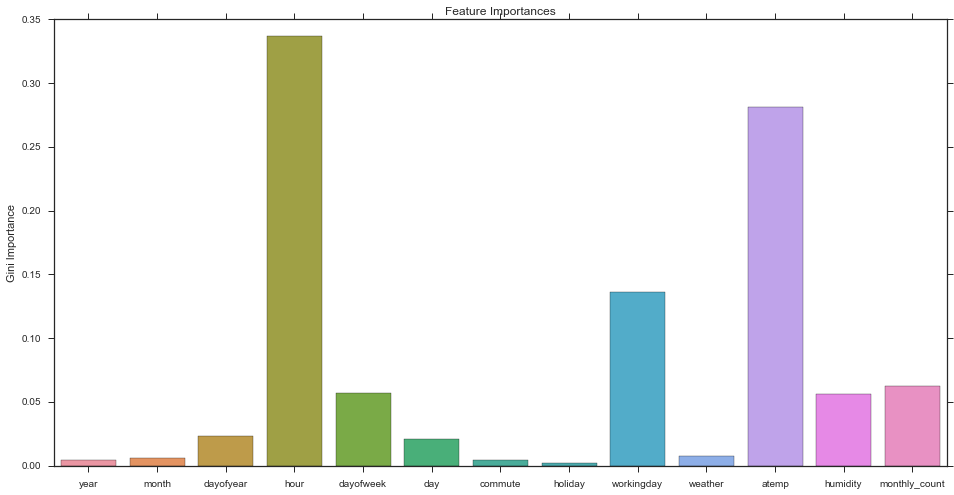

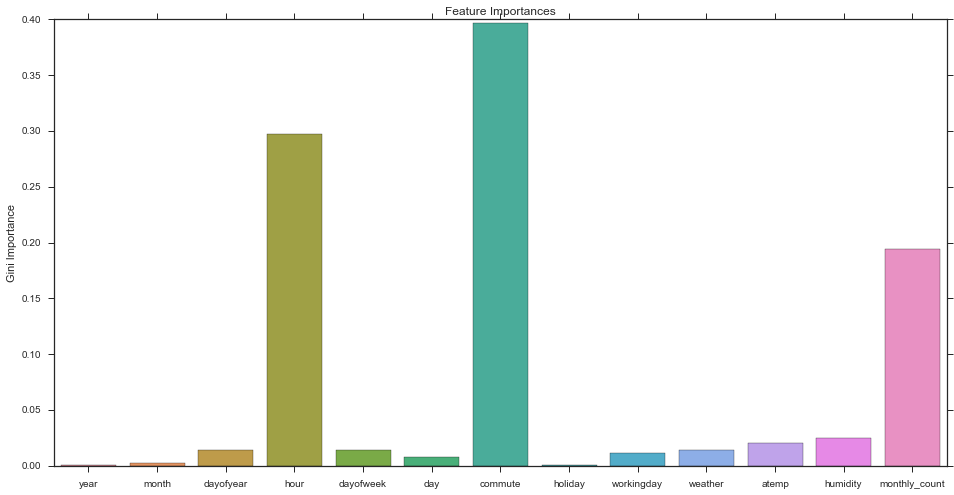

In [26]:
# Split into train and dev set
x_train, x_dev, y_train, y_dev = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)
casual = RandomForestRegressor(n_estimators = 20, max_features = 'auto')
casual.fit(x_train, y_train[:,0])
reg = RandomForestRegressor(n_estimators = 20, max_features = 'auto')
reg.fit(x_train, y_train[:,1])

# Plot feature importances (casual)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df_train.columns.values[:-3], y=casual.feature_importances_)
title = plt.title("Feature Importances")
ylabel = plt.ylabel("Gini Importance")
# Plot feature importances (registered)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df_train.columns.values[:-3], y=reg.feature_importances_)
title = plt.title("Feature Importances")
ylabel = plt.ylabel("Gini Importance")

Casual users are driven moe by the temperature and whether the day is a weekday or weekend. Registered users are driven by the commute hours and monthly trend (registered users are more persistent) instead. Perhaps this is expected, but it is nice to see that our model confirms some real-life intuitions.

### Error Analysis
We now turn to error analysis. We can plot all the errors so we can deduce what our model is missing.

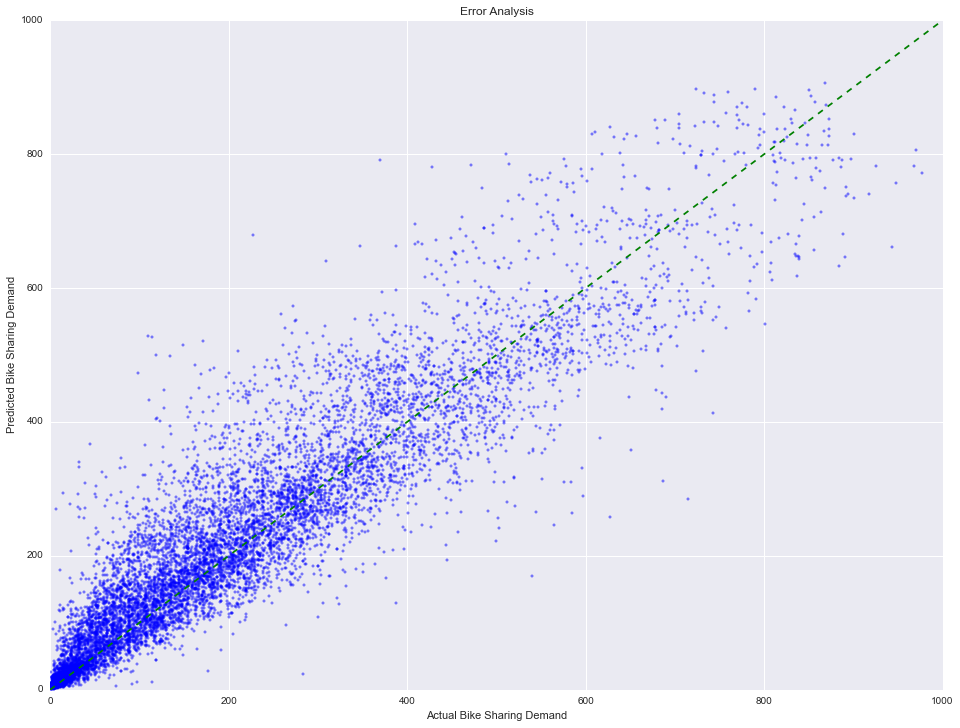

In [110]:
## Error Analysis (Predicted versus Actual)
plt.figure(figsize = (16,12))
plt.plot(df_train['count'], total_preds, 'bo', markersize=3, alpha=0.5)
plt.plot([0,1000], [0,1000], 'g--')
plt.title('Error Analysis')
plt.xlabel('Actual Bike Sharing Demand')
plt.ylabel('Predicted Bike Sharing Demand')

We see from the error plot that our model tends to underestimate when the actual demand is high (i.e. points tend to fall below the green line at the top right corner). Can we examine the model to see why?

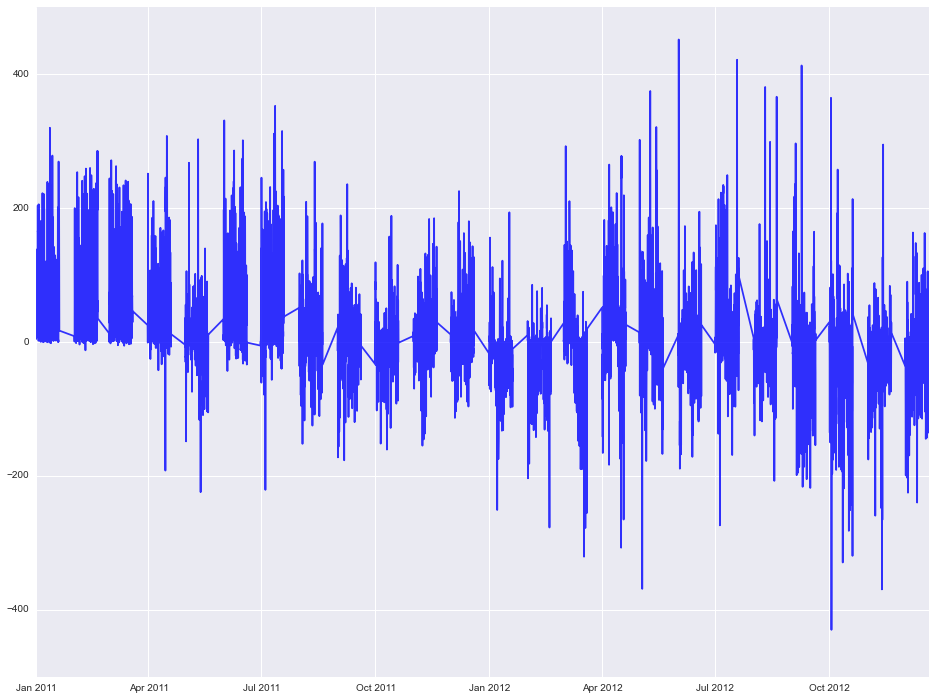

In [131]:
## Error Analysis (errors over time)
errors = total_preds-df_train['count']
plt.figure(figsize = (16,12))
plt.plot(df_train.index, errors, 'b', alpha=0.8)

It appears that the errors have more variance over time. This could be due to the fact that the variance of the outcome variable is increasing (shown in a previous plot). Can we improve this behavior with additional time series modeling?  

### Attribution of Improvements
#### KC will complete

### Next Steps
#### Daniel

In [27]:
## Write results in Kaggle format
casual.fit(train_data, train_labels[:,0])
reg.fit(train_data, train_labels[:,1])
kaggle_preds = casual.predict(test_data) + reg.predict(test_data)

# Write to csv
out_path = '/Users/InfernoIX/datasets/bike/kaggle_submission.csv'
df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_preds}, columns = ["datetime", "count"])
df_submission.to_csv(out_path, index=False)